In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binsreg import *
import seaborn as sns
import warnings

# ignore warnings:
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_theme(style='whitegrid')

In [102]:
def binned_scatter(x, y, q, marker='o', dispersion=False, label=None):
    # Convert x to a pandas Series if needed
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    # Compute percentile rank for each observation (values between 0 and 1)
    x_pct = x.rank(method='average', pct=True)
    
    # Create quantile bins on the percentile ranks
    x_binned, bin_edges = pd.qcut(x_pct, q=q, retbins=True, duplicates='drop')
    bin_centers = []
    binned_means = []
    binned_median = []
    binned_min = []
    binned_max = []
    
    # Compute statistics within each bin (using the percentile x-values)
    for interval in x_binned.unique():
        x_in_bin = x_pct[x_binned == interval]
        y_in_bin = y[x_binned == interval]
        bin_center = x_in_bin.mean()
        mean_val = y_in_bin.mean()
        median_val = y_in_bin.median()
        # Dispersion: 25th and 75th percentiles of y
        min_val = y_in_bin.quantile(0.25)
        max_val = y_in_bin.quantile(0.75)
        bin_centers.append(bin_center)
        binned_means.append(mean_val)
        binned_median.append(median_val)
        binned_min.append(min_val)
        binned_max.append(max_val)
    
    # Sort results by bin centers
    sorted_indices = np.argsort(bin_centers)
    bin_centers = np.array(bin_centers)[sorted_indices]
    binned_means = np.array(binned_means)[sorted_indices]
    binned_median = np.array(binned_median)[sorted_indices]
    binned_min = np.array(binned_min)[sorted_indices]
    binned_max = np.array(binned_max)[sorted_indices]
    
    # Plot the mean values
    plt.scatter(bin_centers, binned_means, marker=marker, alpha=1, s=50, edgecolors='black', label=label)
    
    # Optionally plot additional dispersion markers
    if dispersion:
        plt.scatter(bin_centers, binned_median, marker=marker, alpha=0.7, s=50, color='green')
        plt.scatter(bin_centers, binned_min, marker=marker, alpha=0.7, s=50, color='grey')
        plt.scatter(bin_centers, binned_max, marker=marker, alpha=0.7, s=50, color='grey')
    
    # Label the axes
    xlabel = f'Percentile Rank of {x.name}' if x.name else 'Percentile Rank'
    plt.xlabel(xlabel)
    plt.ylabel(y.name if hasattr(y, 'name') else 'y')
    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5, color='lightgrey')
    
    # Set x-ticks from 0 to 100
    tick_positions = np.linspace(0, 1, 6)
    tick_labels = [f'{int(val*100)}' for val in tick_positions]
    plt.xticks(tick_positions, tick_labels)

### Class and variables

In [103]:
class CallReports:
    def __init__(self, folder_path, essential_vars=None):
        """
        Initialize the analysis class with the folder path where 'call_reports.csv' is stored.
        
        Parameters:
          folder_path (str): Path to the folder containing 'call_reports.csv'.
          essential_vars (list, optional): List of columns that must always be included.
                Defaults to ['IDRSSD', 'Financial Institution Name', 'Date'].
        """
        self.folder_path = folder_path
        # Build full path for the call_reports.csv file.
        self.file_path = os.path.join(folder_path, "call_reports.csv")
        
        if essential_vars is None:
            self.essential_vars = ['IDRSSD', 'Financial Institution Name', 'Date']
        else:
            self.essential_vars = essential_vars
        
        # DataFrames will be loaded later, once variables to select are provided.
        self.df_selected = None
        self.df_constructed = None
        self.df_balanced = None

    def select_variables(self, variables=None):
        """
        Select a subset of columns for analysis and load only those columns from the CSV file.
        Essential variables are always included.
        
        Also, check for duplicate columns that come in pairs ending with '_x' and '_y'. For each pair,
        compute the maximum gap (absolute difference) between the entries. The maximum gap is printed,
        and if the gap is zero, the '_y' column is dropped (keeping the '_x' column).
        
        Finally, reorder the columns so that the essential variables (self.essential_vars)
        and the 'Year' column (if it exists) are the first columns in the DataFrame.
        
        Parameters:
        variables (list, optional): Additional variable names to include besides essential ones.
                                        If None, only essential variables will be selected.
        
        Returns:
        DataFrame with the selected (and cleaned) columns, with essential_vars and 'Year' ordered first.
        """
        # Combine the essential variables and any additional requested variables.
        if variables is None:
            vars_to_select = self.essential_vars.copy()
        else:
            vars_to_select = list(set(self.essential_vars + variables))
        
        # Read only the header of the CSV to know which columns exist.
        try:
            df_header = pd.read_csv(self.file_path, nrows=0)
        except Exception as e:
            raise IOError(f"Error reading file header from {self.file_path}: {e}")
        
        available_in_file = df_header.columns.tolist()
        
        # Warn if some requested variables are not in the file.
        missing_vars = [v for v in vars_to_select if v not in available_in_file]
        if missing_vars:
            print("Warning: The following variables are not in the data and will be skipped:", missing_vars)
        
        # Determine the final list of columns to load.
        available_vars = [v for v in vars_to_select if v in available_in_file]
        
        # Load only the selected columns from the CSV.
        self.df_selected = pd.read_csv(self.file_path, usecols=available_vars)
        
        # Ensure the 'Date' column is converted to datetime if present.
        if 'Date' in self.df_selected.columns:
            self.df_selected['Date'] = pd.to_datetime(self.df_selected['Date'], errors='coerce')
        
        # Check for duplicate variables that come with suffixes '_x' and '_y'.
        for col in self.df_selected.columns:
            if col.endswith("_x"):
                base = col[:-2]  # Remove the '_x' suffix
                col_y = base + "_y"
                if col_y in self.df_selected.columns:
                    try:
                        # Compute maximum absolute difference ("gap") between the two columns.
                        gap = (self.df_selected[col] - self.df_selected[col_y]).abs().max()
                    except Exception as e:
                        # If subtraction fails (e.g., non-numeric data), compare equality.
                        diff = self.df_selected[col] != self.df_selected[col_y]
                        gap = 0 if not diff.any() else "Mismatch"
                    
                    print(f"Duplicate variable {base}: max gap between {col} and {col_y} is {gap}")
                    
                    # If the gap is zero, drop the duplicate '_y' column.
                    if gap == 0:
                        print(f"Dropping duplicate column {col_y} as it is identical to {col}.")
                        self.df_selected.drop(columns=[col_y], inplace=True)
        
        # Reorder columns: ensure that the columns in essential_vars and 'Year'
        # are the first columns, followed by the rest in their original order.
        order_cols = []
        for col in self.essential_vars:
            if col in self.df_selected.columns:
                order_cols.append(col)
        if 'Year' in self.df_selected.columns:
            order_cols.append('Year')
        # Append any remaining columns that were not in order_cols.
        other_cols = [col for col in self.df_selected.columns if col not in order_cols]
        self.df_selected = self.df_selected[order_cols + other_cols]
        
        return self.df_selected
        
        
    def compare_variables(self, var_RCFD, var_RCON):
        """
        Compare two columns (e.g., a RCFD column and a RCON column).
        
        Returns:
          A dictionary with counts for:
            - both_valid: Observations where both are not NaN.
            - RCFD_only: Observations where only var_RCFD is not NaN.
            - RCON_only: Observations where only var_RCON is not NaN.
            - both_NaN: Observations where both are NaN.
          
        Note: This function requires that select_variables() has been run.
        """
        if self.df_selected is None:
            raise ValueError("Data has not been subset. Please run select_variables() first.")
        
        for var in [var_RCFD, var_RCON]:
            if var not in self.df_selected.columns:
                raise ValueError(f"Column {var} is not available in the selected DataFrame.")
        
        df_subset = self.df_selected[[var_RCFD, var_RCON]]
        both_valid = df_subset.dropna().shape[0]
        rcf_only = ((df_subset[var_RCFD].notna()) & (df_subset[var_RCON].isna())).sum()
        rcon_only = ((df_subset[var_RCON].notna()) & (df_subset[var_RCFD].isna())).sum()
        both_nan = ((df_subset[var_RCFD].isna()) & (df_subset[var_RCON].isna())).sum()
        
        return {
            "both_valid": both_valid,
            "RCFD_only": rcf_only,
            "RCON_only": rcon_only,
            "both_NaN": both_nan
        }

    def construct_definitions(self, mappings):
        """
        Construct new variables, handling MDRM code changes at specific switch_dates.
        
        Parameters:
            mappings (list): Each mapping dictionary may contain:
                - 'new_var': Name of the new variable.
                - 'first_col', 'second_col': Column names for initial period.
                - 'method': (optional) Combination method ('secondary', 'first', 'min', 'max', 'mean', 'sum').
                - 'mask_zeros': (optional) if True, mask zeros as NaN.
                - 'switch_date': (optional) date the MDRM codes change.
                - 'first_col_post', 'second_col_post': (optional) Column names after switch_date.
                If these are not provided, the original columns are used throughout.
                
        Returns:
            DataFrame with constructed variables appended.
            
        -------------------------------------- Examples --------------------------------------
        1) For a variable that changes MDRM codes, we use the 'switch_date' to determine when to switch columns.
        Suppose the variable "Held-to-maturity securities" changes MDRM codes on 2019-03-31:        
            mappings = [
                {
                    "new_var": "Held-to-maturity securities",
                    "first_col": "RCFD1754",
                    "second_col": "RCON1754",
                    "switch_date": "2019-03-31",
                    "first_col_post": "RCFDJJ34",
                    "second_col_post": "RCONJJ34",
                    "method": "secondary",
                    "mask_zeros": True
                }
            ]
        
        Then, the resulting series is constructed as:
        
            Date          Columns used
            -------------------------------------
            2018-12-31 → RCFD1754 & RCON1754
            2019-03-30 → RCFD1754 & RCON1754
            ------------------------------------- switch_date = 2019-03-31
            2019-03-31 → RCFDJJ34 & RCONJJ34
            2020-06-30 → RCFDJJ34 & RCONJJ34
        
        For a variable without code changes, such as "Total Loans":
        
            mappings = [
                {
                    "new_var": "Total Loans",
                    "first_col": "RCON2122",
                    "second_col": "RCON2122",
                    "method": "secondary",
                    "mask_zeros": True
                }
            ]
        
        The resulting series uses the same columns across all dates:
        
            Date          Columns used
            -------------------------------------
            2005-12-31 → RCON2122
            2019-03-31 → RCON2122
            2023-12-31 → RCON2122
        """
        if self.df_selected is None:
            raise ValueError("Please run select_variables() first.")
            
        df = self.df_selected.copy()

        for mapping in mappings:
            new_var = mapping['new_var']
            df[new_var] = np.nan

            method = mapping.get('method', 'secondary')
            mask_zeros = mapping.get('mask_zeros', False)
            
            switch_date = pd.Timestamp(mapping.get('switch_date', '2100-01-01'))

            # Before switch_date
            first_col = mapping['first_col']
            second_col = mapping['second_col']
            
            pre_mask = df['Date'] < switch_date
            
            # Function to combine two columns
            def combine_cols(df_slice, col1, col2, method):
                if method == "min":
                    return df_slice[[col1, col2]].min(axis=1)
                elif method == "max":
                    return df_slice[[col1, col2]].max(axis=1)
                elif method == "mean":
                    return df_slice[[col1, col2]].mean(axis=1, skipna=True)
                elif method == "sum":
                    return df_slice[col1].fillna(0) + df_slice[col2].fillna(0)
                elif method == "first":
                    return df_slice[col1].combine_first(df_slice[col2])
                elif method == "secondary":
                    return df_slice[col2].combine_first(df_slice[col1])
                else:
                    raise ValueError(f"Unknown method '{method}'")

            # Apply to pre-switch dates
            result_pre = combine_cols(df.loc[pre_mask], first_col, second_col, method)
            if mask_zeros:
                result_pre = result_pre.mask(result_pre == 0, np.nan)
            df.loc[pre_mask, new_var] = result_pre

            # Apply post-switch if columns provided
            if 'switch_date' in mapping:
                first_col_post = mapping.get('first_col_post', first_col)
                second_col_post = mapping.get('second_col_post', second_col)
                
                post_mask = df['Date'] >= switch_date
                result_post = combine_cols(df.loc[post_mask], first_col_post, second_col_post, method)
                if mask_zeros:
                    result_post = result_post.mask(result_post == 0, np.nan)
                df.loc[post_mask, new_var] = result_post

        self.df_constructed = df
        return df


    def create_balanced_panel(self, df_input=None):
        """
        Transform the given dataset (or the constructed dataset) into a balanced panel by retaining
        only banks (identified by 'IDRSSD') that appear in all dates.
        
        Parameters:
          df_input (DataFrame, optional): The DataFrame to convert. Defaults to using self.df_constructed.
        
        Returns:
          A balanced panel DataFrame.
        """
        if df_input is None:
            if self.df_constructed is None:
                raise ValueError("No constructed DataFrame available. Please run construct_definitions() first.")
            df_input = self.df_constructed
        
        if "IDRSSD" not in df_input.columns or "Date" not in df_input.columns:
            raise ValueError("Both 'IDRSSD' and 'Date' columns must be in the DataFrame for creating a balanced panel.")
        
        n_dates = df_input["Date"].nunique()
        valid_banks = df_input.groupby("IDRSSD")["Date"].nunique()[lambda x: x == n_dates].index
        balanced_df = df_input[df_input["IDRSSD"].isin(valid_banks)].copy()
        self.df_balanced = balanced_df
        return balanced_df

In [104]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'

In [105]:
cr = CallReports(path)

In [106]:
# define maturity variables:
loans_mat_vars = [
                'RCONA564', 'RCONA565', 'RCONA566', 'RCONA567', 'RCONA568', 'RCONA569',     # used
                #'RCFDA564', 'RCFDA565', 'RCFDA566', 'RCFDA567', 'RCFDA568', 'RCFDA569',     # to be tested
                # ------------------------------------------------------------------------------------------------
                'RCFDA570', 'RCFDA571', 'RCFDA572', 'RCFDA573', 'RCFDA574', 'RCFDA575',     # used 
                #'RCONA570', 'RCONA571', 'RCONA572', 'RCONA573', 'RCONA574', 'RCONA575',     # to be tested  
                ]

securities_mat_vars = [
             # --------------------------------------  Treasuries  --------------------------------------
                'RCFDA549', 'RCFDA550', 'RCFDA551', 'RCFDA552', 'RCFDA553', 'RCFDA554',     # used
                'RCONA549', 'RCONA550', 'RCONA551', 'RCONA552', 'RCONA553', 'RCONA554',     # to be tested
            # --------------------------------------  MBS  --------------------------------------
                'RCFDA555', 'RCFDA556', 'RCFDA557', 'RCFDA558', 'RCFDA559', 'RCFDA560',     # used
                'RCONA555', 'RCONA556', 'RCONA557', 'RCONA558', 'RCONA559', 'RCONA560',     # to be tested
                ]


# define the list of variables that will be used
vars = [
             # ------------------------------------------------------------------------------------------------ 
             'Date', 'IDRSSD', 'Financial Institution Name',            # Identifier Variables
             # ------------------------------------------------------------------------------------------------
            'RCON2170', 'RCFD2170',                                     # Total Assets
             # ------------------------------------------------------------------------------------------------
             'RCON2122', 'RCFD2122',                                    # Total Loans
             # ------------------------------------------------------------------------------------------------
             'RCON2200',                                                # Total Deposits
             'RCON2215',                                                # Transaction Deposits
             'RCON6648',                                                # 0-100k
             'RCON2604',                                                # 100k+ (old)
             'RCONJ473',                                                # 100-250k (new)
             'RCONJ474',                                                # 250k+ (new)
             # ------------------------------------------------------------------------------------------------
             'RCONF045', 'RCONF046', 'RCONF047', 
             'RCONF048', 'RCONF049', 'RCONF050',
             'RCONF051', 'RCONF052', 'RCON3645',                        # Uninsured Deposits
             # ------------------------------------------------------------------------------------------------
             'RCON3210', 'RCFD3210',                                    # Total Equity Capital
             'RCONB530', 'RCFDB530',                                    # AOCI
             # ------------------------------------------------------------------------------------------------
             'RCON1754', 'RCFD1754',                                    # HTM Securities Ammortized Cost
             'RCFD1754_x', 'RCFD1754_y', 'RCON1754_x', 'RCON1754_y',
             # ------------------------------------------------------------------------------------------------
             'RCON1771', 'RCFD1771',                                    # HTM Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCON1772', 'RCFD1772',                                    # AFS Securities Ammortized Cost
             # ------------------------------------------------------------------------------------------------
             'RCONJJ34', 'RCFDJJ34',                                    
             'RCONJA22', 'RCFDJA22',                                    # Booked Securities
             # ------------------------------------------------------------------------------------------------
             'RCFD1773_x', 'RCFD1773_y', 'RCON1773',                    # AFS Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCONB987',                                                # FF sold in domestic offices
             'RCONB989', 'RCFDB989',                                    # Resell agreements                                  
             # ------------------------------------------------------------------------------------------------
             'RCFD0081', 'RCON0081',                                    # Cash and Balances Due from Depository Institutions
             'RCFD0071', 'RCON0071',                                    
             # ------------------------------------------------------------------------------------------------
             'RIAD4508',                                                 # Interest Expenses
             'RIADA517', 'RIADA518', 'RIAD0093',
             'RIADHK03', 'RIADHK04'
             ] 

# create a list putting together 'vars', 'loans_mat_vars', and 'securities_mat_vars':
all_vars = vars + loans_mat_vars + securities_mat_vars

In [107]:
main = cr.select_variables(all_vars)

Duplicate variable RCFD1754: max gap between RCFD1754_x and RCFD1754_y is 0.0
Dropping duplicate column RCFD1754_y as it is identical to RCFD1754_x.
Duplicate variable RCFD1773: max gap between RCFD1773_x and RCFD1773_y is 0.0
Dropping duplicate column RCFD1773_y as it is identical to RCFD1773_x.
Duplicate variable RCON1754: max gap between RCON1754_x and RCON1754_y is 0.0
Dropping duplicate column RCON1754_y as it is identical to RCON1754_x.


In [108]:
#cr.df_selected.head(10)
# Matches the other file! 

In [109]:
#last_digits = sorted(list(set([var[-3:] for var in securities_mat_vars])))

#for x in last_digits:
#    print('---------------------------------------------------------------------------------')
#    print('For x = ', x)
#    vars = [
#    'RCFDA' + str(int(x)), 'RCONA' + str(int(x))
#    ]
#    print(cr.compare_variables(vars[0], vars[1]))
# Matches the other file!

In [110]:
#last_digits = sorted(list(set([var[-3:] for var in loans_mat_vars])))
#last_digits = [int(x) for x in last_digits]
#last_digits = [x for x in last_digits if x < 570]

#for x in last_digits:
#    print('---------------------------------------------------------------------------------')
#    vars = [
#    'RCFDA' + str(x+6), 'RCONA' + str(x)
#    ]
#    print(vars[0], vars[1])
#    print(cr.compare_variables(vars[0], vars[1]))

# Matches the other file!   

In [111]:
mappings = [
    # Loans: Total Loans = RCON2122.combine_first(RCFD2122), then mask zeros.
    {
        "first_col": "RCON2122",
        "second_col": "RCON2122",
        "new_var": "Total Loans",
        "method": "secondary",   # Gives RCON2122 if available, else RCFD2122.
        "mask_zeros": True
    },
    # Assets: Create Total Assets from RCON2170 and mask zeros.
    {
        "first_col": "RCFD2170",
        "second_col": "RCON2170",
        "new_var": "Total Assets",
        "method": "secondary",   # Since both are the same, this simply copies RCON2170.
        "mask_zeros": True
    },
    # Equity Capital: Create Total Equity Capital from RCON3210 and RCFD3210 and mask zeros.
    {
        "first_col": "RCON3210",
        "second_col": "RCFD3210",
        "new_var": "Total Equity Capital",
        "method": "secondary",   # Since both are the same, this simply copies RCON3210.
        "mask_zeros": True
    },
    # AOCI: Create AOCI from RCONB530 and RCFDB530 and mask zeros.
    {
        "first_col": "RCONB530",
        "second_col": "RCFDB530",
        "new_var": "AOCI",
        "method": "secondary",   # Since both are the same, this simply copies RCONB530.
        "mask_zeros": True
    },
    # ********************************************************************************************************
    # ****************************************** Security Variables ******************************************
    # ********************************************************************************************************
    # ------------------------------------------ INTERMEDIATE STEPS ------------------------------------------
    # Create RCON1754_right = RCON1754_x.combine_first(RCON1754)
    {
        "new_var":              "RCON1754_right",
        "first_col":            "RCON1754",      # fallback column
        "second_col":           "RCON1754_x",   # primary column
        "method":               "secondary"
    },
    # Create RCFD1754_right = RCFD1754_x.combine_first(RCFD1754)
    {
        "new_var":              "RCFD1754_right",
        "first_col":            "RCFD1754",      # fallback column
        "second_col":           "RCFD1754_x",   # primary column
        "method":               "secondary"
    },
    # Create 1754_right from RCFD1754_right and RCON1754_right
    # This takes the row-wise minimum:
    {
        "new_var":              "1754_right",
        "first_col":            "RCFD1754_right",
        "second_col":           "RCON1754_right",
        "method":               "secondary"
    },
        # Create '1771_right' from RCON1771 and RCFD1771:
    {
        "new_var":              "1771_right",
        "first_col":            "RCFD1771",
        "second_col":           "RCON1771",
        "method":               "secondary"
    },
    # Create 1772_right from RCFD1772 and RCON1772:
    {
        "new_var":              "1772_right",
        "first_col":            "RCFD1772",
        "second_col":           "RCON1772",
        "method":               "secondary"
    },
    # Create B989_right from RCFDB989 and RCONB989:
    {
        "new_var":              "B989_right",
        "first_col":            "RCFDB989",
        "second_col":           "RCONB989",
        "method":               "secondary",
      },
    # ------------------------------------------ VARIABLES ------------------------------------------
    {
        "new_var":          "HTM Securities",
        "first_col":        "1754_right",       
        "second_col":       "1754_right",
        "switch_date":      "2019-03-31",           # First date with the new MDRM code.
        "first_col_post":   "RCFDJJ34",
        "second_col_post":  "RCONJJ34",
        "method":           "secondary",
    },
    # Create AFS Securities from RCON1773 and RCFD1773_x:
    {
        "new_var":          "AFS Securities",
        "first_col":        "RCFD1773_x",
        "second_col":       "RCON1773",
        "method":           "secondary",
    },
    # Create 'Securities AC' from 1754_right and 1772_right:
    {
        "new_var":          "Securities AC",
        "first_col":        "1754_right",
        "second_col":       "1772_right",
        "method":           "sum",
        "mask_zeros":       True
    },
    # Create 'Securities Fair Value' from 1771_right and AFS Securities:
    {
        "new_var":          "Securities FV",
        "first_col":        "1771_right",
        "second_col":       "AFS Securities",
        "method":           "sum",
        "mask_zeros":       True
    },
    # Create 'Equity Securities' from 'RCFDJA22' and 'RCONJA22':
    {
        "new_var":          "Equity Securities",
        "first_col":        "RCFDJA22",
        "second_col":       "RCONJA22",
        "method":           "secondary",
    },
    # Create FFS from B989_right and RCONB987:
    {
        "new_var":          "FFS",
        "first_col":        "B989_right",
        "second_col":       "RCONB987",
        "method":           "sum",
        "mask_zeros":       True
    },
    # ********************************************************************************************************
    # ************************************************* Cash *************************************************
    # ********************************************************************************************************
    # Create 0081_right from RCFD0081 and RCON0081:
    {
        "new_var":          "0081_right",
        "first_col":        "RCFD0081",
        "second_col":       "RCON0081",
        "method":           "secondary",   
    },
    # Create 0071_right from RCFD0071 and RCON0071:
    {
        "new_var":          "0071_right",
        "first_col":        "RCFD0071",
        "second_col":       "RCON0071",
        "method":           "secondary",   
    },
    # Create 'Cash' from 0081_right and 0071_right:
    {
        "new_var":          "Cash",
        "first_col":        "0081_right",
        "second_col":       "0071_right",
        "method":           "sum",
        "mask_zeros":       True
    },
    # ********************************************************************************************************
    # *********************************************** Deposits ***********************************************
    # ********************************************************************************************************
    # Create Total Deposits from RCON2200 (a simple copy) and mask zeros.
    {
        "new_var":          "Total Deposits",
        "first_col":        "RCON2200",
        "second_col":       "RCON2200",
        "method":           "secondary",   # Since both are the same, this simply copies RCON2200.
        "mask_zeros":       True
    },
    # Create 'Insured Deposit Accounts' from RCONF049 and RCONF045:
    {
        "new_var":          "Insured Deposit Accounts",
        "first_col":        "RCONF049",
        "second_col":       "RCONF045",
        "method":           "sum",
        "mask_zeros":       True
    },
    # Create 'Number of Insured Deposit Accounts' from RCONF050 and RCONF046:
    {
        "new_var":          "Number of Insured Deposit Accounts",
        "first_col":        "RCONF050",
        "second_col":       "RCONF046",
        "method":           "sum",
    },
    # Create 'Uninsured Deposit Accounts' from RCONF051 and RCONF047:
    {
        "new_var":          "Uninsured Deposit Accounts",
        "first_col":        "RCONF051",
        "second_col":       "RCONF047",
        "method":           "sum",
    },
    # Create 'Number of Uninsured Deposit Accounts' from RCONF052 and RCONF048:
    {
        "new_var":          "Number of Uninsured Deposit Accounts",
        "first_col":        "RCONF052",
        "second_col":       "RCONF048",
        "method":           "sum",
    },
    # Create 'Transaction Deposits' from RCON2215 (a simple copy) and mask zeros.
    {
        "new_var":          "Transaction Deposits",
        "first_col":        "RCON2215",
        "second_col":       "RCON2215",
        "method":           "secondary",   # Since both are the same, this simply copies RCON2215.
        "mask_zeros":       True
    },
    # helper bucket: large TDs once J-codes appear
    #{
    #    "new_var":      "TD_large_post",
    #    "first_col":    "RCONJ473",      # $100–250 k
    #    "second_col":   "RCONJ474",      # > $250 k
    #    "method":       "sum",
    #    "mask_zeros":   True
    #},

    # total time deposits (small + large)
    {
        "new_var":          "Time Deposits",
        "first_col":        "RCON6648",       # < $100 k
        "second_col":       "RCON2604",       # ≥ $100 k (pre-2010)
        "method":           "sum",
        "mask_zeros":       True
    },

    # ********************************************************************************************************
    # ****************************************** Interest Expenses *******************************************
    # ********************************************************************************************************
    # Create 'Transaction Deposit Expenses' from RIAD4508:
    {
        "new_var":          "Transaction Deposit Expenses",
        "first_col":        "RIAD4508",
        "second_col":       "RIAD4508",  # Since both are the same, this simply copies RCON2215.
        "method":           "secondary", 
        "mask_zeros":       True
    },
    # Create 'Time Deposit Expenses' from RIADA517 and RIADA518 (pre-2017) or RIADHK03 and RIADHK04 (post-2017):
    {
        "new_var":          "Time Deposit Expenses",
        # pre-2017 codes (FDIC cap = $100k)
        "first_col":        "RIADA518",      # interest on TDs < $100k
        "second_col":       "RIADA517",      # interest on TDs ≥ $100k
        # post-2017 codes (FDIC cap = $250k)
        "switch_date":      "2017-03-31",    # first quarter with HK-codes
        "first_col_post":   "RIADHK03",      # interest on TDs ≤ $250k
        "second_col_post":  "RIADHK04",      # interest on TDs  > $250k
        "method":           "sum"            # add the two buckets each quarter
    }
    ]
# Create all the new variables:
main = cr.construct_definitions(mappings=mappings)

In [112]:
# Create 'Insured Deposit Accounts' and 'Number of Insured Deposit Accounts'
main['Insured Deposit Accounts'] = main['RCONF045'] + main['RCONF049']
main['Number of Insured Deposit Accounts'] = main['RCONF046'] + main['RCONF050']

# Create 'Uninsured Deposit Accounts' and 'Number of Uninsured Deposit Accounts'
main['Uninsured Deposit Accounts'] = main['RCONF047'] + main['RCONF051']
main['Number of Uninsured Deposit Accounts'] = main['RCONF048'] + main['RCONF052']

# Correct insurance coverage threshold based on date:
main['Insurance Coverage'] = np.where(main['Date'] < pd.Timestamp('2010-03-01'), 100, 250)

# Recalculate 'Insured Deposits' considering coverage threshold:
main['Insured Deposits'] = (
    main['Insured Deposit Accounts'] +
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Recalculate 'Uninsured Deposits':
main['Uninsured Deposits'] = (
    main['Uninsured Deposit Accounts'] -
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Create 'Total Deposits 2':
main['Total Deposits 2'] = main['Insured Deposits'] + main['Uninsured Deposits']

In [113]:
# Recompute 'Time Deposits Expenses' considering that it accumulates over 'Year'. We want expenses per 'Date'. Use 
# groupby(['IDRSSD, 'Year']):
main['Time Deposit Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Time Deposit Expenses']
    .diff().fillna(main['Time Deposit Expenses'])
)

# Do the same for 'Transaction Deposit Expenses':
main['Transaction Deposit Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Transaction Deposit Expenses']
    .diff().fillna(main['Transaction Deposit Expenses'])
)


## Begenau et. al (2025)

In [132]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 
           'Total Assets', 'HTM Securities', 'AFS Securities', 'FFS', 'Equity Securities', 'Cash',
           'Transaction Deposits', 'Time Deposits', 'Time Deposit Expenses', 'Transaction Deposit Expenses',]]

In [ ]:
# Keep 2010Q1 to 2022Q4:
#df = df[(df['Date'] >= '2010-01-01') & (df['Date'] <= '2022-12-31')]

In [133]:
df['Log Total Assets'] = np.log(df['Total Assets'])

# Create 'Securities and FFS per Asset':
df['Total Securities'] = df['HTM Securities'].fillna(0) + df['AFS Securities'].fillna(0) + df['Equity Securities'].fillna(0)
df['Securities per Assets'] = df['Total Securities'] / df['Total Assets']
df['Securities and FFS per Asset'] = (df['Total Securities'] + df['FFS']) / df['Total Assets']
df['Cash, Securities and FFS per Asset'] = (df['Cash'] + df['Total Securities'] + df['FFS']) / df['Total Assets']
# Define 'Cash per Asset':
df['Cash per Asset'] = df['Cash'] / df['Total Assets']

C:\Users\angel\AppData\Local\Temp\ipykernel_8068\2988522337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\angel\AppData\Local\Temp\ipykernel_8068\2988522337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\angel\AppData\Local\Temp\ipykernel_8068\2988522337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

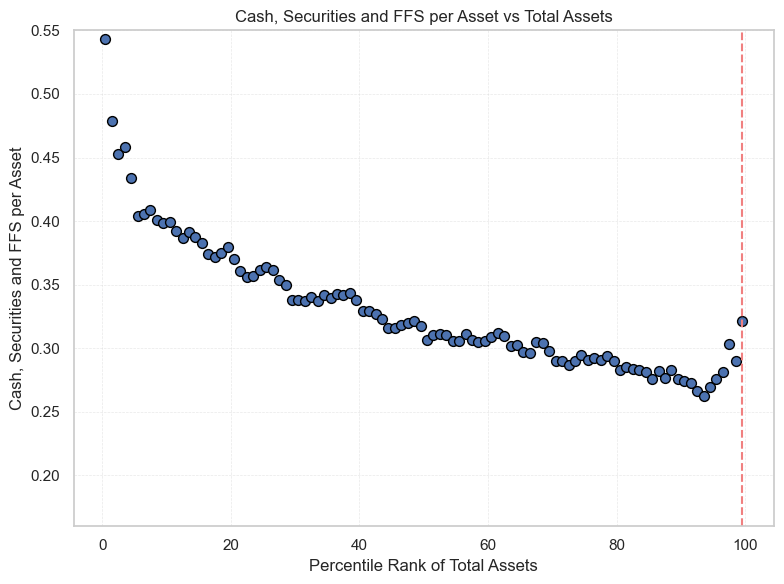

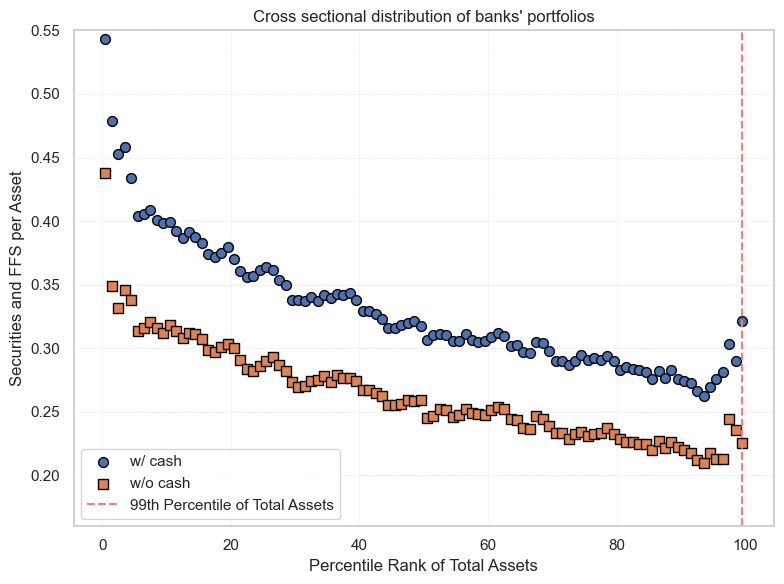

In [134]:
# make a scatter plot of 'Cash, Securities and FFS per Asset' vs 'Total Assets' using seaborn:
plt.figure(figsize=(8, 6))
binned_scatter(df['Total Assets'], df['Cash, Securities and FFS per Asset'], q=100, marker='o', dispersion=False)
plt.axvline(x=.995, color='lightcoral', linestyle='--', label='99th Percentile of Total Assets')
plt.title('Cash, Securities and FFS per Asset vs Total Assets')
plt.ylim(0.16, 0.55)
plt.tight_layout()
plt.show()

# make a scatter plot of 'Securities and FFS per Asset' vs 'Total Assets' using seaborn:
plt.figure(figsize=(8, 6))
binned_scatter(df['Total Assets'], df['Cash, Securities and FFS per Asset'], q=100, marker='o', dispersion=False, label='w/ cash')
binned_scatter(df['Total Assets'], df['Securities and FFS per Asset'], q=100, marker='s', dispersion=False, label='w/o cash')
plt.legend()
plt.axvline(x=.995, color='lightcoral', linestyle='--', label='99th Percentile of Total Assets')
plt.title("Cross sectional distribution of banks' portfolios")
plt.legend(['w/ cash', 'w/o cash', '99th Percentile of Total Assets'])
plt.ylim(0.16, 0.55)
plt.tight_layout()

In [135]:
# Create a subset keeping only banks in the top 1% of Total Assets per Date
df_top1 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.quantile(0.99))]

# Do the same, for the top 10, 20, and 50 nlargest banks per Date in Total Assets:
df_top5 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.nlargest(5).min())]
df_top10 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.nlargest(10).min())]
df_top20 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.nlargest(20).min())]
df_top50 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.nlargest(50).min())]

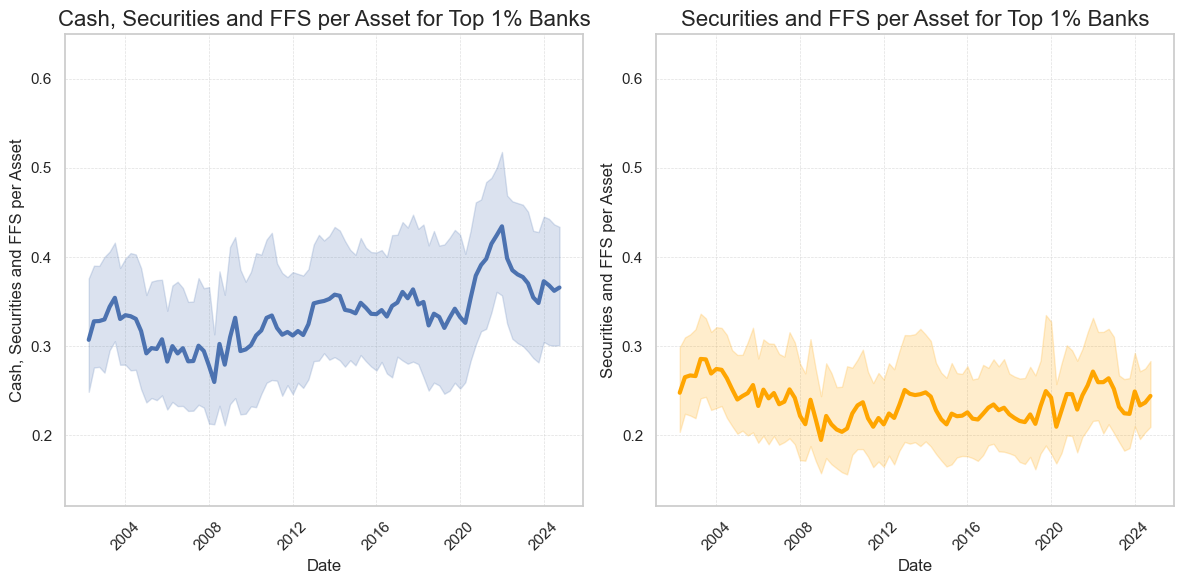

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plot for "Cash, Securities and FFS per Asset"
sns.lineplot(data=df_top1, x='Date', y='Cash, Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=ax1, lw=3)
ax1.set_title('Cash, Securities and FFS per Asset for Top 1% Banks', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cash, Securities and FFS per Asset')
ax1.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0.12, 0.65)

# Plot for "Securities and FFS per Asset"
sns.lineplot(data=df_top1, x='Date', y='Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=ax2, lw=3, color='orange')
ax2.set_title('Securities and FFS per Asset for Top 1% Banks', fontsize=16)
ax2.set_xlabel('Date')
ax2.set_ylabel('Securities and FFS per Asset')
ax2.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0.12, 0.65)

plt.tight_layout()
plt.show()

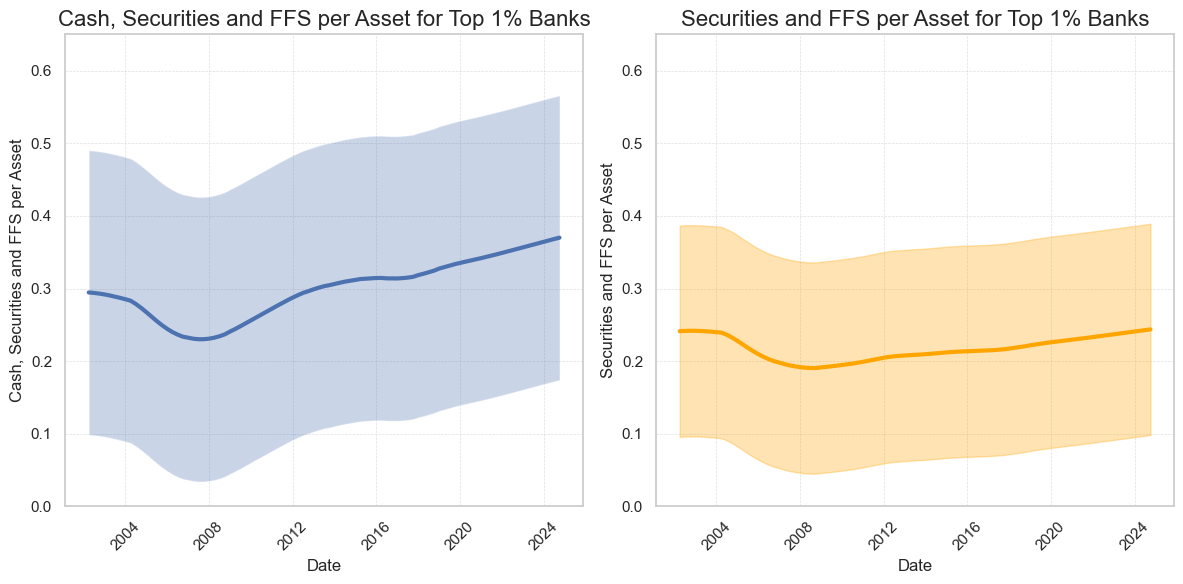

In [138]:
import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

# Convert dates to numeric values for smoothing
date_nums = mdates.date2num(df_top1['Date'])

# Compute LOESS smoothed values (adjust frac as needed)
loess_cash = lowess(df_top1['Cash, Securities and FFS per Asset'], date_nums, frac=0.3)
loess_sec = lowess(df_top1['Securities and FFS per Asset'], date_nums, frac=0.3)

# Compute residual standard deviations for each series (using interpolation)
sigma_cash = np.std(df_top1['Cash, Securities and FFS per Asset'] - 
                    np.interp(date_nums, loess_cash[:, 0], loess_cash[:, 1]))
sigma_sec = np.std(df_top1['Securities and FFS per Asset'] - 
                   np.interp(date_nums, loess_sec[:, 0], loess_sec[:, 1]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plot LOESS for "Cash, Securities and FFS per Asset"
dates_cash = mdates.num2date(loess_cash[:, 0])
ax1.plot(dates_cash, loess_cash[:, 1], lw=3)
ax1.fill_between(dates_cash, loess_cash[:, 1] - sigma_cash, loess_cash[:, 1] + sigma_cash, 
                 alpha=0.3)
ax1.set_title('Cash, Securities and FFS per Asset for Top 1% Banks', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cash, Securities and FFS per Asset')
ax1.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
ax1.tick_params(axis='x', rotation=45)

# Plot LOESS for "Securities and FFS per Asset"
dates_sec = mdates.num2date(loess_sec[:, 0])
ax2.plot(dates_sec, loess_sec[:, 1], color='orange', lw=3)
ax2.fill_between(dates_sec, loess_sec[:, 1] - sigma_sec, loess_sec[:, 1] + sigma_sec, 
                 color='orange', alpha=0.3)
ax2.set_title('Securities and FFS per Asset for Top 1% Banks', fontsize=16)
ax2.set_xlabel('Date')
ax2.set_ylabel('Securities and FFS per Asset')
ax2.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
ax2.tick_params(axis='x', rotation=45)

# Set the same y-axis limits for both subplots
common_ylim = (0, 0.65)
ax1.set_ylim(common_ylim)
ax2.set_ylim(common_ylim)

plt.tight_layout()
plt.show()

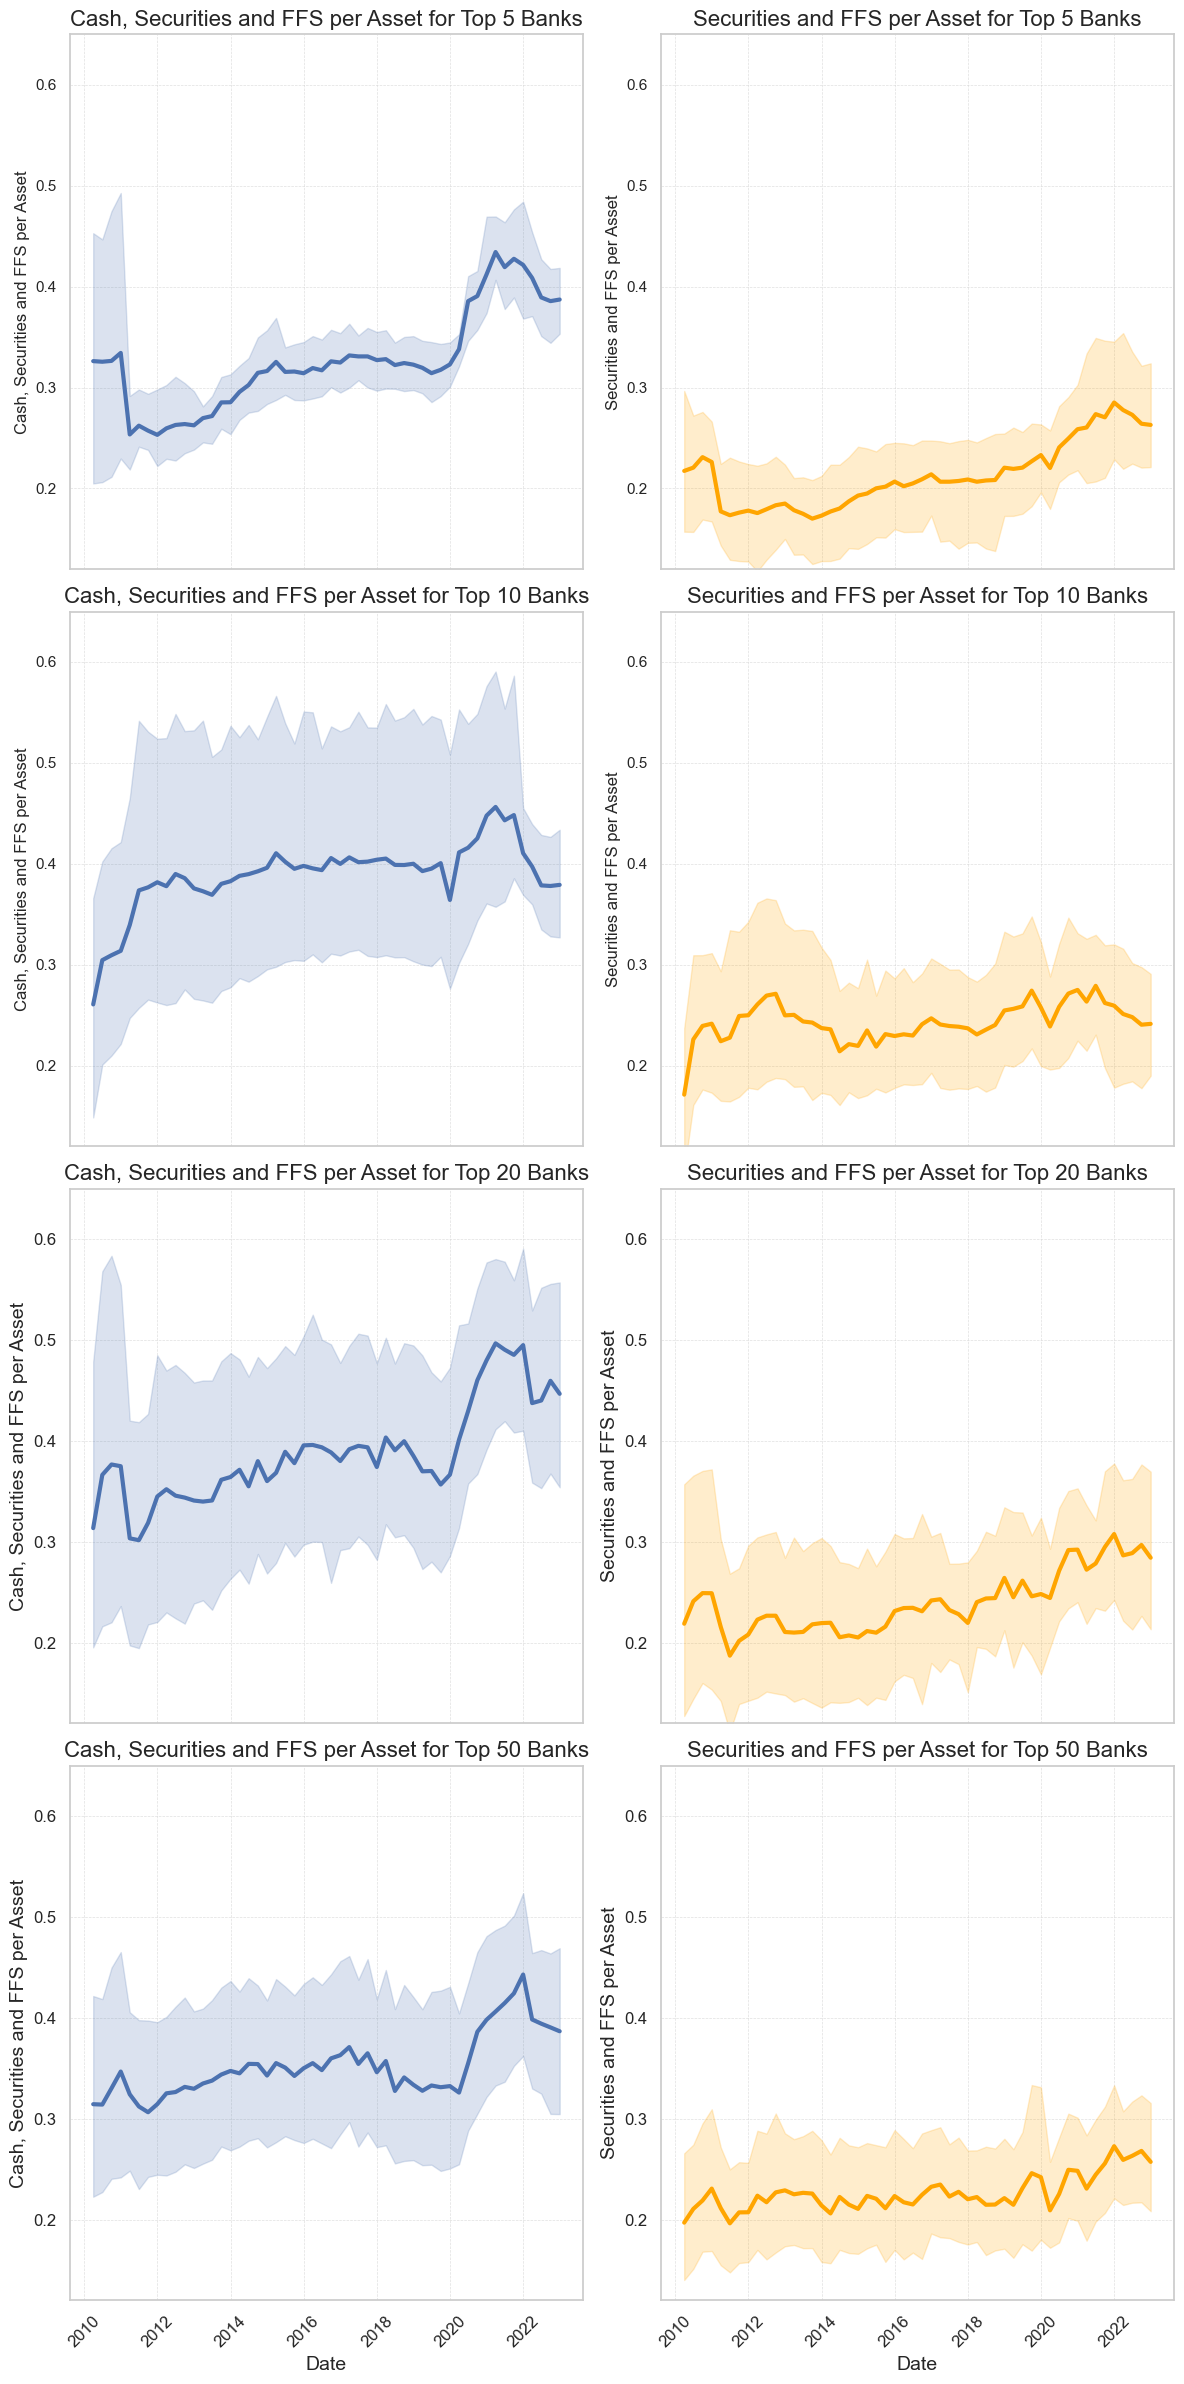

In [120]:
# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(12, 24), sharex=True)

# Row 0: Top 5 Banks
sns.lineplot(data=df_top5, x='Date', y='Cash, Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=axes[0, 0], lw=3)
axes[0, 0].set_title('Cash, Securities and FFS per Asset for Top 5 Banks', fontsize=16)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cash, Securities and FFS per Asset')
axes[0, 0].grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(0.12, 0.65)

sns.lineplot(data=df_top5, x='Date', y='Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=axes[0, 1], lw=3, color='orange')
axes[0, 1].set_title('Securities and FFS per Asset for Top 5 Banks', fontsize=16)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Securities and FFS per Asset')
axes[0, 1].grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0.12, 0.65)

# Row 1: Top 10 Banks
sns.lineplot(data=df_top10, x='Date', y='Cash, Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=axes[1, 0], lw=3)
axes[1, 0].set_title('Cash, Securities and FFS per Asset for Top 10 Banks', fontsize=16)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Cash, Securities and FFS per Asset')
axes[1, 0].grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(0.12, 0.65)

sns.lineplot(data=df_top10, x='Date', y='Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=axes[1, 1], lw=3, color='orange')
axes[1, 1].set_title('Securities and FFS per Asset for Top 10 Banks', fontsize=16)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Securities and FFS per Asset')
axes[1, 1].grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(0.12, 0.65)

# Row 2: Top 20 Banks
sns.lineplot(data=df_top20, x='Date', y='Cash, Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=axes[2, 0], lw=3)
axes[2, 0].set_title('Cash, Securities and FFS per Asset for Top 20 Banks', fontsize=16)
axes[2, 0].set_xlabel('Date', fontsize=14)
axes[2, 0].set_ylabel('Cash, Securities and FFS per Asset', fontsize=14)
axes[2, 0].grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
axes[2, 0].tick_params(axis='x', rotation=45, labelsize=12)
axes[2, 0].tick_params(axis='y', labelsize=12)
axes[2, 0].set_ylim(0.12, 0.65)

sns.lineplot(data=df_top20, x='Date', y='Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=axes[2, 1], lw=3, color='orange')
axes[2, 1].set_title('Securities and FFS per Asset for Top 20 Banks', fontsize=16)
axes[2, 1].set_xlabel('Date', fontsize=14)
axes[2, 1].set_ylabel('Securities and FFS per Asset', fontsize=14)
axes[2, 1].grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
axes[2, 1].tick_params(axis='x', rotation=45)
axes[2, 1].tick_params(axis='y', labelsize=12)
axes[2, 1].set_ylim(0.12, 0.65)

# Row 3: Top 50 Banks
sns.lineplot(data=df_top50, x='Date', y='Cash, Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=axes[3, 0], lw=3)
axes[3, 0].set_title('Cash, Securities and FFS per Asset for Top 50 Banks', fontsize=16)
axes[3, 0].set_xlabel('Date', fontsize=14)
axes[3, 0].set_ylabel('Cash, Securities and FFS per Asset', fontsize=14)
axes[3, 0].grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
axes[3, 0].tick_params(axis='x', rotation=45, labelsize=12)
axes[3, 0].tick_params(axis='y', labelsize=12)
axes[3, 0].set_ylim(0.12, 0.65)

sns.lineplot(data=df_top50, x='Date', y='Securities and FFS per Asset', 
             errorbar=('ci', 99), ax=axes[3, 1], lw=3, color='orange')
axes[3, 1].set_title('Securities and FFS per Asset for Top 50 Banks', fontsize=16)
axes[3, 1].set_xlabel('Date', fontsize=14)
axes[3, 1].set_ylabel('Securities and FFS per Asset', fontsize=14)
axes[3, 1].grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
axes[3, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[3, 1].tick_params(axis='y', labelsize=12)
axes[3, 1].set_ylim(0.12, 0.65)

plt.tight_layout()
plt.show()

In [19]:
# Create 'Time Deposit Rates':
df['Time Deposit Rates'] = df['Time Deposit Expenses'] / df['Time Deposits']

In [33]:
# drop bottom and top 1% of 'Time Deposit Rates':
df = df[(df['Time Deposit Rates'] >= df['Time Deposit Rates'].quantile(0.01)) & 
        (df['Time Deposit Rates'] <= df['Time Deposit Rates'].quantile(0.99))]

## Regional Banking Crisis (2023)

### Scatter plots

#### Plots for the whole sample of banks

In [ ]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 'Total Loans', 'Total Deposits', 'Total Assets', 'Uninsured Deposits',
           'AOCI', 'Total Equity Capital',
           'Securities AC',  'Securities FV']].copy()

In [ ]:
df = df[(df['Date']=='2019-03-31') | (df['Date']=='2021-12-31')]
df = df.sort_values(by=['IDRSSD', 'Date']).reset_index(drop=True)

In [ ]:
# Get the total number of unique dates in the DataFrame
total_dates = df['Date'].nunique()

# Identify banks that appear in all dates
banks_all_dates = df.groupby('IDRSSD')['Date'].nunique() == total_dates
banks_to_keep = banks_all_dates[banks_all_dates].index

# Filter the DataFrame to keep only these banks
df = df[df['IDRSSD'].isin(banks_to_keep)].reset_index(drop=True)

In [ ]:
failed_banks = [802866, 4114567, 3437483]
#failed_banks = [802866, 4114567]

In [ ]:
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCON1772', 'RCFD1772', '1772_right']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCON1754_right', 'RCFD1754_right', '1754_right']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', '1772_right', '1754_right', 'Securities AC']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCON2170', 'RCFD2170']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCON3210', 'RCFD3210']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCONB530', 'RCFDB530']].sort_values(by='Date')

In [ ]:
# compute the growth rate of 'Securities AC' and 'Total Loans', and 'Total Deposits':
df['Securities AC Growth'] = df.groupby('IDRSSD')['Securities AC'].pct_change(fill_method=None)
df['Securities FV Growth'] = df.groupby('IDRSSD')['Securities FV'].pct_change(fill_method=None)
df['Loans Growth'] = df.groupby('IDRSSD')['Total Loans'].pct_change(fill_method=None)
df['Deposits Growth'] = df.groupby('IDRSSD')['Total Deposits'].pct_change(fill_method=None)
df['Uninsured Deposits Growth'] = df.groupby('IDRSSD')['Uninsured Deposits'].pct_change(fill_method=None)
df['Equity Capital Growth'] = df.groupby('IDRSSD')['Total Equity Capital'].pct_change(fill_method=None)
df['AOCI Growth'] = df.groupby('IDRSSD')['AOCI'].pct_change(fill_method=None)

In [ ]:
# Drop the rows with NaN values in the 'Securities AC Growth' column
df = df.dropna(subset=['Securities AC Growth', 'Securities FV Growth', 'Equity Capital Growth', 'AOCI Growth', 'Uninsured Deposits Growth',
                        'Loans Growth', 'Deposits Growth', 'Total Assets'])

# show the top 20 banks with the highest growth rate in 'Securities AC Growth':
df.sort_values(by='Securities AC Growth', ascending=False, inplace=True)

In [ ]:
test = df[['IDRSSD', 'Financial Institution Name', 'Total Assets', 'Deposits Growth', 'Securities AC Growth', 'Loans Growth']].head(100)
# take the minimum assets of test:
print(test['Total Assets'].min()*1000/10e5, test['Total Assets'].max()*1000/10e5)
print(test['Securities AC Growth'].min(), test['Securities AC Growth'].max())
test['Total Assets (Millions)'] = test['Total Assets'].apply(lambda x: x*1000/10e5)
outliers_securities = test[['IDRSSD', 'Financial Institution Name', 'Total Assets (Millions)', 'Deposits Growth', 'Securities AC Growth', 'Loans Growth']].head(100)['IDRSSD']

In [ ]:
# exclude outliers_securities from the main DataFrame:
df2 = df[~df['IDRSSD'].isin(outliers_securities)].reset_index(drop=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Deposits Growth'], df2['Securities AC Growth'], marker='.')
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Deposit Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks1 = ax1.get_yticks()
#ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 8)
ax1.set_ylim(-1.1, 8)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Deposits Growth'], df2['Loans Growth'], marker='.')
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Deposit Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
ax2.set_xticks(ticks2)
lims2 = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
         max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xlim(-1.1, 8)
ax2.set_ylim(-1.1, 8)
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Deposits Growth'], df2['Equity Capital Growth'], marker='.')
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Deposit Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax3.get_xlim()[0], ax3.get_ylim()[0]),
         max(ax3.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1.1, 8)
ax3.set_ylim(-1.1, 8)
plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Uninsured Deposits Growth'], df2['Securities AC Growth'], marker='.')
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Uninsured Deposits Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Uninsured Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks1 = ax1.get_yticks()
#ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 8)
ax1.set_ylim(-1.1, 8)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Uninsured Deposits Growth'], df2['Loans Growth'], marker='.')
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Uninsured Deposit Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Uninsured Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
ax2.set_xticks(ticks2)
lims2 = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
         max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xlim(-1.1, 8)
ax2.set_ylim(-1.1, 8)
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Uninsured Deposits Growth'], df2['Equity Capital Growth'], marker='.')
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Uninsured Deposit Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Uninsured Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax3.get_xlim()[0], ax3.get_ylim()[0]),
         max(ax3.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1.1, 8)
ax3.set_ylim(-1.1, 8)
plt.tight_layout()
plt.show()

In [ ]:
# make the same scatter plot with 'Deposit Growth' in the x-axis and 'Uninsured Deposits Growth' in the y-axis:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df2['Deposits Growth'], df2['Uninsured Deposits Growth'], marker='.')
ax.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            marker='s', s=100, color='orange')
ax.set_xlabel('Deposit Growth', fontsize=16)
ax.set_ylabel('Uninsured Deposits Growth', fontsize=16)
ax.set_title('Deposit Growth vs. Uninsured Deposits Growth', fontsize=18)
ax.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks = ax.get_yticks()
#ax.set_xticks(ticks)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, linestyle='--', color='black', alpha=0.5)
ax.set_xlim(-1.1, 8)
ax.set_ylim(-1.1, 8)
ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

#### Plots for top X% banks

In [ ]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 'Total Loans', 'Total Deposits', 'Total Assets', 'Uninsured Deposits',
           'AOCI', 'Total Equity Capital',
           'Securities AC', 'Securities FV']].copy()


In [ ]:
df = df[(df['Date']=='2019-03-31') | (df['Date']=='2021-12-31')]
df = df.sort_values(by=['IDRSSD', 'Date']).reset_index(drop=True)

In [ ]:
# Get the total number of unique dates in the DataFrame
total_dates = df['Date'].nunique()

# Identify banks that appear in all dates
banks_all_dates = df.groupby('IDRSSD')['Date'].nunique() == total_dates
banks_to_keep = banks_all_dates[banks_all_dates].index

# Filter the DataFrame to keep only these banks
df = df[df['IDRSSD'].isin(banks_to_keep)].reset_index(drop=True)

In [ ]:
# create auxiliar dataset with only '2019-03-31':
df_aux = df[df['Date'] == '2019-03-31'].copy()

In [ ]:
# take the top 1% banks in 'Total Assets' in '2019-03-31':
percentile = 0.99
top_percentile_assets = df_aux['Total Assets'].quantile(percentile)
top_percentile_deposits = df_aux['Total Deposits'].quantile(percentile)

In [ ]:
# filter the DataFrame to keep only these banks:
df_top_percentile = df_aux[df_aux['Total Assets'] >= top_percentile_assets].reset_index(drop=True)
top_percent_banks = df_top_percentile['IDRSSD'].unique()

In [ ]:
# --- 1.  Prepare figure with 3 columns instead of 2 --------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# --- 2.  Your two cumulative-histogram panels (unchanged) --------------------
ax1.hist(np.log(df['Total Assets']), bins=50, cumulative=True,
         color='skyblue', alpha=0.7, density=True)
ax1.set_title(f'Cumulative Distribution of Total Assets '
              f'(Top {np.round(100*(1-percentile),1)}% Banks)', fontsize=18)
ax1.set_xlabel('log(Total Assets)', fontsize=16);  ax1.set_ylabel('Density', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(ls=':', color='lightgrey');  
ax1.axvline(np.log(top_percentile_assets), ls='--', color='lightcoral',
            label=f'{percentile}th Percentile')
ax1.legend(fontsize=12)

ax2.hist(np.log(df['Total Deposits']), bins=50, cumulative=True,
         color='skyblue', alpha=0.7, density=True)
ax2.set_title(f'Cumulative Distribution of Total Deposits '
              f'(Top {np.round(100*(1-percentile),1)}% Banks)', fontsize=18)
ax2.set_xlabel('log(Total Deposits)', fontsize=16);  ax2.set_ylabel('Density', fontsize=16)
ax2.grid(ls=':', color='lightgrey')
ax2.axvline(np.log(top_percentile_deposits), ls='--', color='lightcoral',
            label=f'{percentile}th Percentile')
ax2.legend(fontsize=14, frameon=False)

# --- 3.  Lorenz-style concentration panel -----------------------------------
def lorenz_points(series):
    s = np.sort(series.values)                  # ascending order
    cum_val  = np.cumsum(s) / s.sum()          # cumulative share of variable
    cum_bank = np.arange(1, len(s)+1) / len(s) # cumulative share of banks
    return cum_bank, cum_val

plot_specs = [
    ('Total Deposits', 'skyblue', 'Deposits'),
    ('Total Assets',       'lightcoral',    'Assets'),
#    ('Uninsured Deposits', 'green',   'Uninsured Deposits'),
#    ('Securities AC',      'orange', 'Securities (AC)')
]

for col, clr, lbl in plot_specs:
    x, y = lorenz_points(df[col].fillna(0))
    ax3.scatter(x, y, s=18, color=clr, alpha=0.85, label=lbl)

ax3.set_title('Concentration of Uninsured Deposits and Assets',
              fontsize=18)
ax3.set_xlabel('Share of Banks', fontsize=16);  ax3.set_ylabel('Share of Total', fontsize=16)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-0.02, 1.02);                ax3.set_ylim(-0.02, 1.02)
ax3.grid(ls=':', color='lightgrey')
ax3.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
df2 = df[df['IDRSSD'].isin(top_percent_banks)].sort_values(by='Total Assets', ascending=False)
df2.sort_values(by=['Date', 'Total Assets'], ascending=[True, False], inplace=True)

In [ ]:
# compute the growth rate of 'Securities AC' and 'Total Loans', and 'Total Deposits':
df2['Securities AC Growth'] = df2.groupby('IDRSSD')['Securities AC'].pct_change(fill_method=None)
df2['Securities FV Growth'] = df2.groupby('IDRSSD')['Securities FV'].pct_change(fill_method=None)
df2['Loans Growth'] = df2.groupby('IDRSSD')['Total Loans'].pct_change(fill_method=None)
df2['Deposits Growth'] = df2.groupby('IDRSSD')['Total Deposits'].pct_change(fill_method=None)
df2['Uninsured Deposits Growth'] = df2.groupby('IDRSSD')['Uninsured Deposits'].pct_change(fill_method=None)
df2['Equity Capital Growth'] = df2.groupby('IDRSSD')['Total Equity Capital'].pct_change(fill_method=None)
df2['AOCI Growth'] = df2.groupby('IDRSSD')['AOCI'].pct_change(fill_method=None)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Deposits Growth'], df2['Securities AC Growth'], marker='o', s=50)
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Deposits Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
ticks1 = ax1.get_yticks()
ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 6)
ax1.set_ylim(-1.1, 6)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Deposits Growth'], df2['Loans Growth'], marker='o', s=50)
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Deposit Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
lims2 = [min(ax2.get_xlim()[0]-1, ax2.get_ylim()[0]),
         max(ax2.get_xlim()[1]-1, ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xticks(ticks2)
ax2.set_yticks(ticks2)
ax2.set_xlim(-0.5, 3)
ax2.set_ylim(-0.5, 3)
# use the same ticks for both axes
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Deposits Growth'], df2['Equity Capital Growth'], marker='o', s=50)
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Deposit Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax3.get_xlim()[0]-1, ax3.get_ylim()[0]),
         max(ax3.get_xlim()[1]-1, ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
#ax3.set_xlim(-0.5, 2)
#ax3.set_ylim(-0.5, 2)
plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Uninsured Deposits Growth'], df2['Securities AC Growth'], marker='o', s=50)
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Uninsured Deposit Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Uninsured Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks1 = ax1.get_yticks()
#ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 6)
ax1.set_ylim(-1.1, 6)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Uninsured Deposits Growth'], df2['Loans Growth'], marker='o', s=50)
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Uninsured Deposits Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Uninsured Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
lims2 = [min(ax2.get_xlim()[0]-1, ax2.get_ylim()[0]),
         max(ax2.get_xlim()[1]-1, ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xticks(ticks2)
ax2.set_yticks(ticks2)
ax2.set_xlim(-0.5, 3)
ax2.set_ylim(-0.5, 3)
# use the same ticks for both axes
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Uninsured Deposits Growth'], df2['Equity Capital Growth'], marker='o', s=50)
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Uninsured Deposits Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Uninsured Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax3.get_xlim()[0]-1, ax3.get_ylim()[0]),
         max(ax3.get_xlim()[1]-1, ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1, 4)
ax3.set_ylim(-1, 4)
plt.tight_layout()
plt.show()

In [ ]:
# make the same scatter plot with 'Deposit Growth' in the x-axis and 'Uninsured Deposits Growth' in the y-axis:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df2['Deposits Growth'], df2['Uninsured Deposits Growth'], marker='.')
ax.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            marker='s', s=100, color='orange')
ax.set_xlabel('Deposit Growth', fontsize=16)
ax.set_ylabel('Uninsured Deposits Growth', fontsize=16)
ax.set_title('Deposit Growth vs. Uninsured Deposits Growth', fontsize=18)
ax.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks = ax.get_yticks()
#ax.set_xticks(ticks)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, linestyle='--', color='black', alpha=0.5)
ax.set_xlim(-1.1, 6)
ax.set_ylim(-1.1, 6)
ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

### AOCI and MTM Losses

In [ ]:
df_temp = main.copy()
#final_date = pd.Timestamp('2023-01-01')
final_date = df_temp['Date'].max()

In [ ]:
df_temp['Total Securities'] = df_temp['HTM Securities'].fillna(0) + df_temp['AFS Securities'].fillna(0) #+ df_temp['Equity Securities'].fillna(0)
df_temp['AOCI %'] = (df_temp['AOCI'] / df_temp['Total Assets']) * 100
# compute the difference between 'Securities Booked' and 'Securities FV':
df_temp['MTM Losses HTM'] = -(df_temp['Total Securities'] - df_temp['Securities FV'])
df_temp['MTM Losses %'] = 100*((df_temp['MTM Losses HTM']+df_temp['AOCI']) / df_temp['Total Assets'])

In [ ]:
# Compute weighted average AOCI among other banks by total assets
weighted_avg_aoci = (
    df_temp[['Date', 'AOCI %', 'Total Assets']]
    .groupby('Date')
    .apply(lambda x: (x['AOCI %'] * x['Total Assets']).sum() / x['Total Assets'].sum())
    .sort_index()
    .reset_index(name='AOCI %')
)

# Compute simple average AOCI among other banks
simple_avg_aoci = (
    df_temp[['Date', 'AOCI %']]
    .groupby('Date')
    .mean()
    .sort_index()
    .reset_index()
)

In [ ]:
weighted_avg_mtm = (
    df_temp[['Date', 'MTM Losses %', 'Total Assets']]
    .groupby('Date')
    .apply(lambda x: (x['MTM Losses %'] * x['Total Assets']).sum() / x['Total Assets'].sum())
    .sort_index()
    .reset_index(name='MTM Losses %')
)

# Compute simple average AOCI among other banks
simple_avg_mtm = (
    df_temp[['Date', 'MTM Losses %']]
    .groupby('Date')
    .mean()
    .sort_index()
    .reset_index()
)

In [ ]:
# aggregate the MTM losses by date and plot using df_temp['Date'] as x-axis:
mtm_agg = df_temp.groupby('Date')['MTM Losses HTM'].sum().reset_index().sort_values('Date')
# rename MTM Losses to MTM Losses HTM:
mtm_agg['MTM Losses AFS'] = df_temp.groupby('Date')['AOCI'].sum().reset_index().sort_values('Date')['AOCI']
# multiply by 1000 to convert to billions:
mtm_agg['MTM Losses HTM'] = mtm_agg['MTM Losses HTM'] * 1000 / 1e9
mtm_agg['MTM Losses AFS'] = mtm_agg['MTM Losses AFS'] * 1000 / 1e9


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
# ----------------------------------------------------------------------------------------------
# Plot 1: AOCI Time Series
sns.lineplot(ax=axes[0], data=weighted_avg_aoci, x='Date', y='AOCI %', 
             label='Weighted Average AOCI', linewidth=4, color='skyblue')
sns.lineplot(ax=axes[0], data=simple_avg_aoci, x='Date', y='AOCI %', 
             label='Simple Average AOCI', linewidth=4, linestyle='--')
axes[0].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0].fill_betweenx(y=[-4, 1],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[0].legend(fontsize=15, loc='lower left')
axes[0].set_xlabel('Year', fontsize=16)
axes[0].set_ylabel('AOCI/Total Assets (%)', fontsize=16)
axes[0].set_title('AOCI Time Series', fontsize=18)
axes[0].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[0].set_ylim(-3.5, 1)
axes[0].tick_params(axis='x', labelsize=14, rotation=45)
axes[0].tick_params(axis='y', labelsize=14)
# ----------------------------------------------------------------------------------------------
# Plot 2: Weighted MTM Losses
sns.lineplot(ax=axes[1], data=weighted_avg_mtm, x='Date', y='MTM Losses %',
             lw=4, ci=False, label='Weighted average', linestyle='-', color='skyblue')
sns.lineplot(ax=axes[1], data=simple_avg_mtm, x='Date', y='MTM Losses %',
             lw=4, ci=False, linestyle='--', label='Simple average')
axes[1].axhline(0, lw=1, ls=':', color='black')
axes[1].legend(loc='lower left', fontsize=16)
axes[1].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[1].fill_betweenx(y=[-11, 2.5],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[1].set_xlabel('Date', fontsize=16)
axes[1].set_ylabel('MTM Losses/Total Assets (%)', fontsize=16)
axes[1].set_title('MTM Losses Time Series', fontsize=18)
axes[1].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[1].set_ylim(-3.5, 1)
axes[1].tick_params(axis='x', labelsize=14, rotation=45)
axes[1].tick_params(axis='y', labelsize=14)
# ----------------------------------------------------------------------------------------------
# Plot 3: stacked barplot of MTM losses

# Define a thicker bar width
bar_width = 60  # adjust as needed

# Plot the first (bottom) bar: MTM Losses HTM using the same skyblue as in axes[0] and [2]
axes[2].bar(mtm_agg['Date'], mtm_agg['MTM Losses HTM'], 
            width=bar_width, color='skyblue', label='MTM Losses HTM', edgecolor='black')

# Plot the second bar on top: MTM Losses AFS using the default second palette color
axes[2].bar(mtm_agg['Date'], mtm_agg['MTM Losses AFS'], 
            width=bar_width, bottom=mtm_agg['MTM Losses HTM'], 
            label='MTM Losses AFS', edgecolor='black')

# Set title and labels directly on axes[1]
axes[2].set_title('Total Security Losses', fontsize=18)
axes[2].set_xlabel('Year', fontsize=16)
axes[2].set_ylabel('MTM Losses (in billions)', fontsize=16)

# Configure x-axis to show only years
axes[2].tick_params(axis='x', labelsize=14, rotation=45)
axes[2].fill_betweenx(y=[-800, 200],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[2].legend(fontsize=14, loc='lower left')
axes[2].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[2].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[2].set_ylim(-750, 150)
axes[2].tick_params(axis='y', labelsize=14)
# ----------------------------------------------------------------------------------------------
plt.tight_layout()
plt.show()

In [ ]:
# Get the last available date in 2022
last_date = '2022-12-31'  # Assuming the last date is December 31, 2022

# Select rows corresponding to this last date
data_last = df_temp[df_temp['Date'] == last_date].copy()

# Compute a weighted version of MTM Losses for each bank:
#total_assets_last = data_last['Total Assets'].sum()
#data_last['Weighted MTM Losses'] = data_last['MTM Losses %'] * (data_last['Total Assets'] / total_assets_last)


# Plot the distribution of 'AOCI %'
plt.figure(figsize=(10, 6))
sns.histplot(data=data_last, x='MTM Losses %', bins=50, kde=False, color='skyblue', 
             stat='density', edgecolor='black', linewidth=0.5)
# place a vertical line at SVB's MTM Losses %:
svb_mtm_loss = data_last[data_last['IDRSSD'] == 802866]['MTM Losses %'].values[0]
plt.axvline(svb_mtm_loss, color='lightcoral', linestyle='--', linewidth=2, label='SVB')
# write 'SVB' next to the vertical line:
plt.text(svb_mtm_loss - 1.2, 0.25, 'SVB', color='lightcoral', fontsize=14)
# place a vertical line at Signature Bank's MTM Losses %:
sig_mtm_loss = data_last[data_last['IDRSSD'] == 3437483]['MTM Losses %'].values[0]
plt.axvline(sig_mtm_loss, color='lightcoral', linestyle='--', linewidth=2, label='Signature Bank')
# place a vertical line at First Republic's MTM Losses %:
frb_mtm_loss = data_last[data_last['IDRSSD'] == 4114567]['MTM Losses %'].values[0]
plt.axvline(frb_mtm_loss, color='lightcoral', linestyle='--', linewidth=2, label='First Republic')
#plt.title('Distribution of MTM Losses/Total Assets (%)', fontsize=18)
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7, color='lightgrey')
plt.xlabel('MTM Losses / Total Assets (%)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xlim(-13, 1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()